In [1]:
import gym
import gym.spaces
import gym.wrappers
from multiprocessing import Process
from random import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans

In [2]:
#hyper parameters
randomness = 0.4
randomness_scaler = 0.9
randomness_interval = 20

In [3]:
def run_episode(policy,args,env,show = False):
    rewards = []
    actions = []
    vis_states = []
    
    observation = env.reset()
    while True:
        if show: env.render()
        action = policy(observation,*args)
        vis_states.append(observation)
        actions.append(action)
        observation, reward, done, info = env.step(action) 
        rewards.append(reward)
        if done : 
            vis_states.append(observation)
            break
    return rewards,actions,vis_states

In [4]:
graph = {}
score = {}
clf = None
compressed_graph = None
compressed_score = None

def update(rewards,actions,vis_states,possible_actions,update_randomness):
    global graph,score,randomness,randomness_scaler,clf
    vis_states = list(map(tuple,vis_states))
        
    
    for state in vis_states:
        if state not in score:
            score[state] = {}
            graph[state] = {}
            for action in possible_actions:
                score[state][action] = 0
                graph[state][action] = {}

    L = len(rewards)
    reward = sum(rewards)
    for i in range(L):
        cur_state = vis_states[i]
        nxt_state = vis_states[i + 1]
        action = actions[i]
            
        if nxt_state not in graph[cur_state][action]:
            graph[cur_state][action][nxt_state] = {'reward_sum':0,'cnt':0}

        graph[cur_state][action][nxt_state]['cnt'] += 1
        graph[cur_state][action][nxt_state]['reward_sum'] += reward
        
        reward -= rewards[i]
    
#     mx_th = 50
#     S = graph.keys()
#     eps = 1e-2
#     for t in range(mx_th):
#         done = True
#         for s in S:
#             for action in possible_actions:
#                 norm = 0
#                 old = score[s][action]
#                 new = 0
#                 for nxt in graph[s][action]:
#                     norm += graph[s][action][nxt]['cnt']
#                     new += graph[s][action][nxt]['reward_sum']
#                 if norm == 0: continue
#                 new *= 1.0/norm
#                 if abs(new-old) > eps:
#                     done = False
#                 score[s][action] = new
#         if done: break
    if update_randomness:
        randomness *= randomness_scaler

In [5]:
def compress():
    print("compressing")
    global graph,score,clf,compressed_graph,compressed_score
    action_space = list(graph[list(graph.keys())[0]].keys())
    K = len(graph.keys())
    if K*0.4 > 3:
        K = int(K*0.4)
    K = min(K,300)
    clf = KMeans(n_clusters=K)
    S = list(graph.keys())
    print("fitting")
    clf = clf.fit(S)
    print("predicting")
    F = clf.predict(S)
    print("mapping")
    D = {}
    for i,s in enumerate(S):
        D[s] = F[i]
    compressed_graph = {}
    compressed_score = {}
    
    for s in range(K):
        compressed_graph[s] = {}
        compressed_score[s] = {}
        for action in action_space:
            compressed_graph[s][action] = {}
            compressed_score[s][action] = 0
            
    for s in graph:
        x = D[s]
        for action in action_space:
            for t in graph[s][action]:
                y = D[t]
                if y not in compressed_graph[x][action]:
                    compressed_graph[x][action][y] = {'cnt':0,'reward_sum':0}
                compressed_graph[x][action][y]['cnt'] += graph[s][action][t]['cnt']
                compressed_graph[x][action][y]['reward_sum'] += graph[s][action][t]['reward_sum']

#     mx_th = int(50*0.4/randomness)
#     S = range(K)
#     eps = 1e-2
#     for t in range(mx_th):
#         done = True
#         for s in S:
#             for action in action_space:
#                 norm = 0
#                 old = compressed_score[s][action]
#                 new = 0
#                 for nxt in compressed_graph[s][action]:
#                     norm += compressed_graph[s][action][nxt]['cnt']
#                     new += compressed_graph[s][action][nxt]['reward_sum']
#                 if norm == 0: 
#                     compressed_score[s][action] = 5
#                     continue
#                 new *= 1.0/norm
#                 if abs(new-old) > eps:
#                     done = False
#                 compressed_score[s][action] = new
#         if done: break
    S = range(K)
    for s in S:
        for action in action_space:
            compressed_score[s][action] = 50
            norm = 0
            for nxt in compressed_graph[s][action]:
                cscore = compressed_graph[s][action][nxt]['reward_sum']*compressed_graph[s][action][nxt]['cnt']
                norm += compressed_graph[s][action][nxt]['cnt']
            if norm == 0: continue
            compressed_score[s][action] = cscore/norm


In [6]:
def pick_action(state,action_space):
    global graph,score,clf
    if random() < randomness or clf is None:
        return choice(action_space)
    state = tuple(state)
    state = clf.predict((state,))[0]
    best_actions = [0]
    val = -10**5
    for action in action_space:
        if compressed_score[state][action] > val:
            best_actions = []
            val = compressed_score[state][action]
            
        if abs(compressed_score[state][action] - val) < 1e-2:
            best_actions.append(action)
            
    return choice(best_actions)

In [7]:
def train(env_name,num_episodes,action_space,policy,policy_args,update,file_name):
    F = []
    fenv = gym.make(env_name)
    for i in range(num_episodes):
        print ("start episode #" + str(i+1))
        env = gym.wrappers.Monitor(fenv, "./" + file_name + "-episodes/" + env_name + "#" + str(i),force = True)
        rewards,actions,vis_states = run_episode(policy,policy_args,env)
        update(rewards,actions,vis_states,action_space,clf is not None and i%randomness_interval == randomness_interval-1)
        F.append(sum(rewards))
        env.close()
        if i%randomness_interval == randomness_interval-1: 
            plt.plot(F)
            plt.show()
        if i==0 or i%100 == 99: compress()
        
    plt.plot(F)
    plt.show()
    

start episode #1
compressing
fitting
predicting
mapping
start episode #2
start episode #3
start episode #4
start episode #5
start episode #6
start episode #7
start episode #8
start episode #9
start episode #10
start episode #11
start episode #12
start episode #13
start episode #14
start episode #15
start episode #16
start episode #17
start episode #18
start episode #19
start episode #20


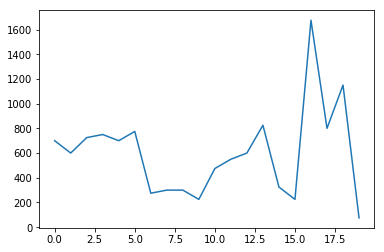

start episode #21
start episode #22
start episode #23
start episode #24
start episode #25
start episode #26
start episode #27
start episode #28
start episode #29
start episode #30
start episode #31
start episode #32
start episode #33
start episode #34
start episode #35
start episode #36
start episode #37
start episode #38
start episode #39
start episode #40


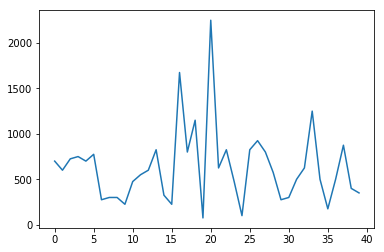

start episode #41
start episode #42
start episode #43
start episode #44
start episode #45
start episode #46
start episode #47
start episode #48
start episode #49
start episode #50
start episode #51
start episode #52
start episode #53
start episode #54
start episode #55
start episode #56
start episode #57
start episode #58
start episode #59
start episode #60


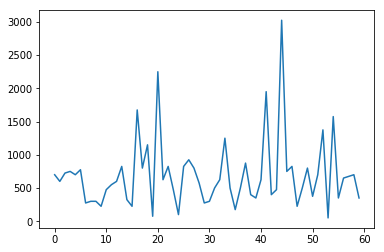

start episode #61
start episode #62
start episode #63
start episode #64
start episode #65
start episode #66
start episode #67
start episode #68
start episode #69
start episode #70
start episode #71
start episode #72
start episode #73
start episode #74
start episode #75
start episode #76
start episode #77
start episode #78
start episode #79
start episode #80


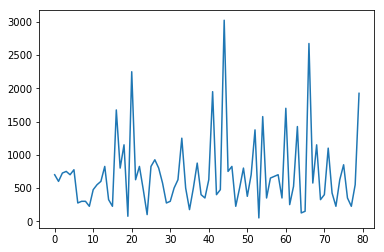

start episode #81
start episode #82
start episode #83
start episode #84
start episode #85
start episode #86
start episode #87
start episode #88
start episode #89
start episode #90
start episode #91
start episode #92
start episode #93
start episode #94
start episode #95
start episode #96
start episode #97
start episode #98
start episode #99
start episode #100


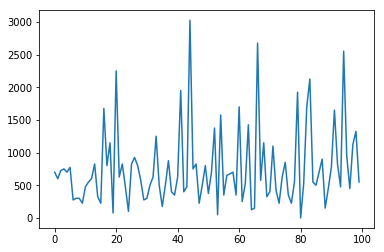

compressing
fitting
predicting
mapping
start episode #101
start episode #102
start episode #103
start episode #104
start episode #105
start episode #106
start episode #107
start episode #108
start episode #109
start episode #110
start episode #111
start episode #112
start episode #113
start episode #114
start episode #115
start episode #116
start episode #117
start episode #118
start episode #119
start episode #120


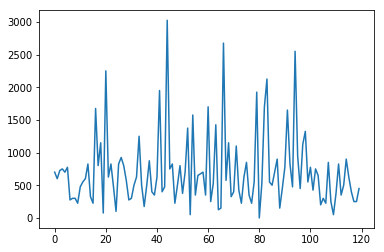

start episode #121
start episode #122
start episode #123
start episode #124
start episode #125
start episode #126
start episode #127
start episode #128
start episode #129
start episode #130
start episode #131
start episode #132
start episode #133
start episode #134
start episode #135
start episode #136
start episode #137
start episode #138
start episode #139
start episode #140


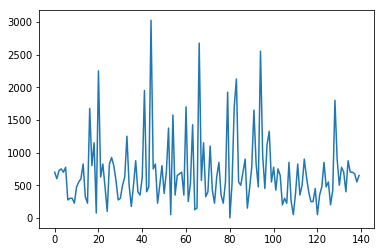

start episode #141
start episode #142
start episode #143
start episode #144
start episode #145
start episode #146
start episode #147
start episode #148
start episode #149
start episode #150
start episode #151
start episode #152
start episode #153
start episode #154
start episode #155
start episode #156
start episode #157
start episode #158
start episode #159
start episode #160


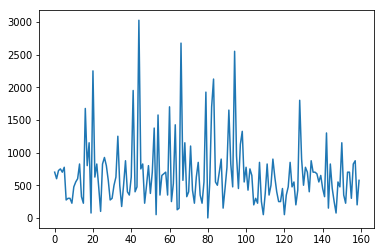

start episode #161
start episode #162
start episode #163
start episode #164
start episode #165
start episode #166
start episode #167
start episode #168
start episode #169
start episode #170
start episode #171
start episode #172
start episode #173
start episode #174
start episode #175
start episode #176
start episode #177
start episode #178
start episode #179
start episode #180


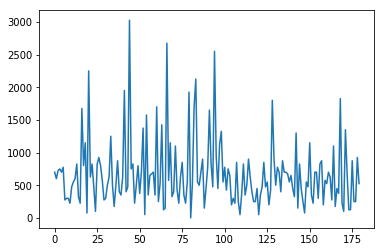

start episode #181
start episode #182
start episode #183
start episode #184
start episode #185
start episode #186
start episode #187
start episode #188
start episode #189
start episode #190
start episode #191
start episode #192
start episode #193
start episode #194
start episode #195
start episode #196
start episode #197
start episode #198
start episode #199
start episode #200


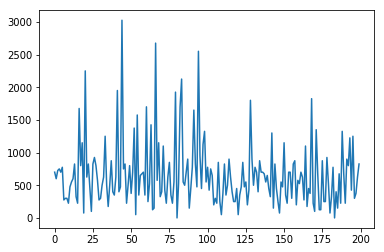

compressing
fitting


KeyboardInterrupt: 

In [8]:
train('AirRaid-ram-v0',500,range(6),pick_action,(range(6),),update,'AirRaid')